# The (un)expected variance at poker
> Enter your winrate and look at the results.

- toc: false
- branch: master
- badges: true
- comments: true
- author: Wilfried F.
- image: variance.png
- categories: [notebook, jupyter, python, poker]

In [2]:
#collapse-hide
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import lru_cache
from scipy import stats

%pylab inline

plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [10]:
#collapse-show
@lru_cache(maxsize=512)
def calculate_variance(totalhands: int, winrate: float = 0.0, dev: float = 100.0, samples: int = 1000):
    """
    Another Poker Variance Calculator like Primedope's one
    Simulate randomly the amount of samples specified with winrate, totalhands and dev as parameters
    Display 20 samples, worst & best samples, 95% and 68% confidence intervals, expected winnings,
         as well as risk of ruin up to 20%
    Print useful numbers about (un)expected variance
     
    Inputs:
        totalhands (int): number of hands e.g. desired length of the samples
        winrate (float): observed (or true) winrate we want to calculate the variance
        dev (float): standard deviation ("Std Dev bb per 100 hands" stat in HM2)
        sample (int): number of samples we want to simulate
    
    """
    #limit number of samples
    if samples > 1_000_000:
        samples = 1_000_000
    
    start = time.time()
       
    h = totalhands//100
    EV = winrate*h
    
    #standard error of the sample mean
    std_dev = dev/(h**0.5)
    
    #probability of loss with such a winrate and standard error
    prob_loss = stats.norm.cdf(0,loc=winrate,scale=std_dev)
    
    #x-axis    
    x = np.arange(0, totalhands + 100, 100)
    
    #expected winnings
    y = [i * winrate for i in range(h+1)]
    
    #put ev values in a dataframe
    df = pd.DataFrame(y, columns=["ev"], index=x)
    
    #confidence intervals
    df["conf1"]= [i * (winrate + std_dev) for i in range(h+1)]
    df["conf2"]= [i * (winrate - std_dev) for i in range(h+1)]
    df["conf3"]= [i * (winrate + 2*std_dev) for i in range(h+1)]
    df["conf4"]= [i * (winrate - 2*std_dev) for i in range(h+1)]
    
    
    #building ramdom samples with loc = winrate and scale = dev
    arr = np.zeros(shape=(samples,h+1)) 
    for i in range(samples):
        arr[i,:]=np.cumsum(np.random.normal(winrate, dev, h+1))
    
    #best and worst EV
    bottom_ten = np.argsort(arr[:,-1])[:10]
    top_ten = np.argsort(arr[:,-1])[-10:]
    
    #bottom line for each sample
    worst_downs = np.array([i for i in np.amin(arr, axis=1)])
    
    #minimum bankroll required for each risk of ruin percentile
    #if the i-th percentile returns a positive value, minimum bankroll required is set to zero
    rr = range(0,101)
    min_bkr = [int(-np.percentile(worst_downs,i)) if np.percentile(worst_downs,i) < 0 else 0 for i in rr]
    rr_df = pd.DataFrame({"Risk of ruin": rr, "Minimum Bankroll": min_bkr})
    rr_df = rr_df.set_index("Risk of ruin")
    
    #best and worst samples
    df["best"] = arr[top_ten[-1],:]
    df["worst"] = arr[bottom_ten[-1],:]
    
    #print computing duration
    print(f'Duration: {time.time() - start}s')
        
    
    plt.figure(figsize=(20,10))
    #select randomly 20 samples to display excluding best and worst samples
    idx_array = [i for i in range(samples) if i not in [top_ten[-1],bottom_ten[-1]]]
    random_idx = np.random.choice(idx_array, 20, replace = False)
    for i in random_idx:    
        plt.plot(x, arr[i,:],linewidth=1)
   
    #display confidence intervals as well as best and worst samples
    fmt=["b","g--","g--","g","g","c","y"]
    labels=["EV","68% confidence interval","","95% confidence interval","","Best", "Worst"]
    for idx, col in enumerate(df.columns):
        df[col] = df[col].astype(int)
        plt.plot(df[col],fmt[idx],linewidth=3,label=labels[idx])
        
    plt.title("Samples over %d hands with confidence intervals" %totalhands)
    plt.xlabel("total hands")
    plt.ylabel("win/loss in big blinds")
    plt.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left')        
    plt.show()
    
    
    #some numbers to print
    ws = [winrate + std_dev, winrate - std_dev, winrate + (2*std_dev), winrate - (2*std_dev)]
    bb = [df.conf1.iloc[-1],df.conf2.iloc[-1],df.conf3.iloc[-1],df.conf4.iloc[-1]] 
    std_dev_bb = int(std_dev*h)    
    
    print (f"Expected winnings: {winrate} bb/100 ({df.ev.iloc[-1]} bb)")
    print (f"Standard deviation after {totalhands} hands: {std_dev: .2f} bb/100 ({std_dev_bb} bb)")
    print("\n")
    print (f"68% confidence interval: {ws[0]:.2f} bb/100 ({bb[0]} bb), {ws[1]:.2f} bb/100 ({bb[1]} bb)")
    print (f"95% confidence interval: {ws[2]:.2f} bb/100 ({bb[2]} bb), {ws[3]:.2f} bb/100 ({bb[3]} bb)")
    print("\n")
    print (f"Top-10 over {samples} samples (bb/100): {np.around(arr[top_ten][:,-1]/h, 2)}")
    print (f"Bottom-10 over {samples} samples (bb/100): {np.around(arr[bottom_ten][:,-1]/h, 2)}")
    print("\n")
    print (f"Probability of loss after {totalhands} hands: {prob_loss:.2%}")
    print("\n")
       
    #display the first 20th percentiles of risk of ruin dataframe
    plt.figure(figsize=(20,10))    
    plt.plot(rr_df)    
    plt.title("Risk of ruin\n(q-th percentile over %s samples merged by their bottom line)" %samples)
    plt.xlabel("risk of ruin %")
    plt.xlim(0,20)
    plt.xticks(range(0,22,2))
    plt.ylabel("minimum bankroll in big blinds")
    plt.show()
    
   
    #return
    

Duration: 0.08999991416931152s


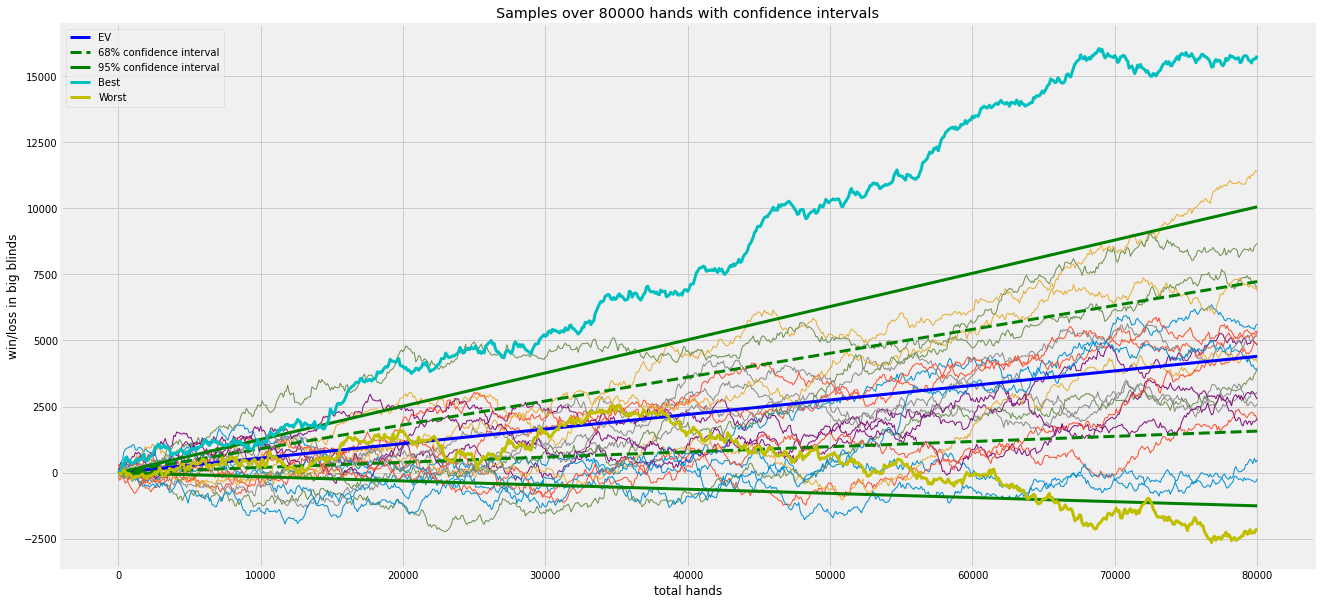

Expected winnings: 5.5 bb/100 (4400 bb)
Standard deviation after 80000 hands:  3.54 bb/100 (2828 bb)


68% confidence interval: 9.04 bb/100 (7228 bb), 1.96 bb/100 (1571 bb)
95% confidence interval: 12.57 bb/100 (10056 bb), -1.57 bb/100 (-1256 bb)


Top-10 over 1000 samples (bb/100): [13.43 13.47 13.52 13.63 13.95 14.22 14.5  15.33 16.   19.72]
Bottom-10 over 1000 samples (bb/100): [-9.83 -5.84 -4.77 -4.06 -3.58 -3.53 -3.25 -2.77 -2.7  -2.66]


Probability of loss after 80000 hands: 5.99%




<Figure size 432x288 with 0 Axes>

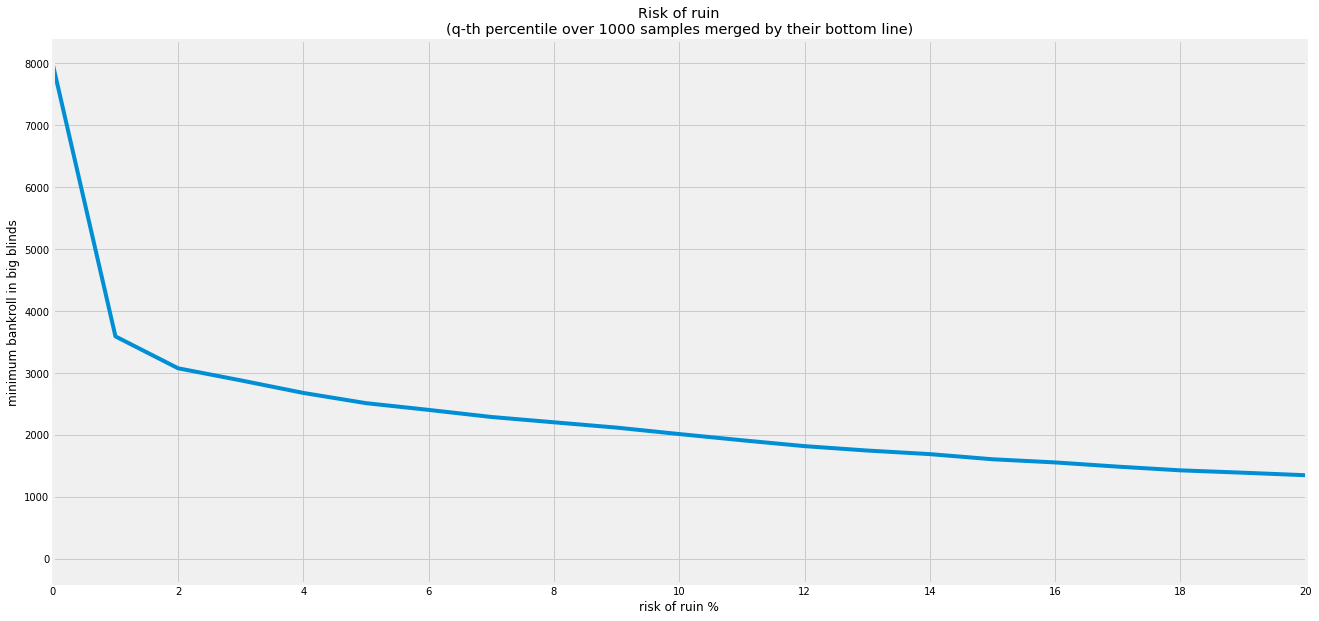

In [11]:
#example
calculate_variance(totalhands = 80000, winrate = 5.5, dev = 100, samples=1000)
